# Circuits

Here we summarise the catalogue circuit components and their underlying physical models.

|           Name           |    Method     |           Circuit Diagram            | Modes |
|:------------------------:|:-------------:|:------------------------------------:|------|
|      Beam splitter       |     `bs`      | ![](../_static/img/beamsplitter.png) | 2    |
|      Phase shifter       |     `ps`      | ![](../_static/img/phaseshifter.png) | 1    |
|       Permutation        |    `perm`     |     ![](../_static/img/perm.png)     | 2+   |
|          Switch          |   `switch`    |    ![](../_static/img/switch.png)    | 2    |
|           Loss           |    `loss`     |     ![](../_static/img/loss.png)     | 1+   |
|           Gate           |    `gate`     |     ![](../_static/img/gate.png)     | 1+   |
|   Haar random unitary    | `haar_random` |     ![](../_static/img/haar.png)     | 1+   |
| Custom scattering matrix |   `custom`    |   ![](../_static/img/custom_u.png)   | 1+   |

The following sections give more detail on each circuit component.

In [32]:
from zpgenerator import *

## Beam splitter

The beam splitter implements a unitary transformation on two modes that is defined by the matrix
$$
\hat{U}_\text{bs} = \begin{pmatrix}
\cos(\theta) & i\sin(\theta)\\
i\sin(\theta) & \cos(\theta)
\end{pmatrix}.
$$

Other variants of the beam splitter, such as the Hadamard unitary, can be implemented by placing the appropriate phase shifters on the input and output ports. Alternatively, the circuit can be constructed using [Perceval's circuit components](https://perceval.quandela.net/docs/components.html) and then converted to ZPGenerator.

The parameters of this component are:

\begin{tabular}{c|l|l}
\text{Symbol}&\text{Description}&\text{ZPG Parameter}\\\hline
$\theta & \text{Beam splitter angle}& \text{`angle'}\\
\end{tabular}

### Examples

The beam splitter defaults to $\theta=\pi/4$, indicating a 50:50 splitting ratio.

In [33]:
c = Circuit.bs()
c.default_parameters

{'angle': 0.7853981633974483}

All circuit elements have a time argument, even if they are time independent. They can be evaluated to a matrix in QuTiP Qobj format.

In [34]:
c.evaluate(t=0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.70710678+0.j         0.        +0.70710678j]
 [0.        +0.70710678j 0.70710678+0.j        ]]

## Phase shifter

The phase shifter implements a unitary transformation on one mode that is defined by the matrix
$$
\hat{U}_\text{ps} = \begin{pmatrix}
e^{i\phi}
\end{pmatrix}.
$$

This impact is only seen relative to the phase of light in other modes. The parameters of this component are:

\begin{tabular}{c|l|l}
\text{Symbol}&\text{Description}&\text{ZPG Parameter}\\\hline
$\phi & \text{Phase shift}& \text{`phase'}\\
\end{tabular}

### Examples

By default, the phase is shifted by $\pi$, which is equivalent to multiplying the amplitude of the light by -1.

In [35]:
c = Circuit.ps()
c.default_parameters

{'phase': 3.141592653589793}

In [36]:
c.evaluate(t=0)

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[-1.]]

## Permutation

The permutation unitary is used to swap modes without having them interact. This is used to organise the locations of the modes so that they can interact properly with other components. The permutation is provided as a list of unique non-negative integers and the order determines the new ordering of the modes. For two modes, the permutation is simply
$$
\hat{U}_\text{perm} = \begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix}.
$$

### Examples

This component has no parameters.

In [37]:
c = Circuit.perm()
c.default_parameters

{}

By default, it swaps two modes.

In [38]:
c.evaluate(0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]

Providing a permutation as a list of integers, we can configure the reordering.

In [39]:
c = Circuit.perm([1, 0, 4, 2, 3])
c.evaluate(0)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = False
Qobj data =
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]

## Switch

The switch is a time-dynamic component used to actively change the spatial mode of light during its evolution. It is a Mach-Zehnder interferometer composed of beam splitters and a phase shifter. The only difference is that the phase of the phase shifter is controlled in time. The parameters of this component are all user-defined.

### Examples

The switch can be instantiated with a function that determines the state of the switch over time. A value of 0 indicates the switch is fully off and all the light is transmitted in the same mode it enters, a value of 1 indicates the switch is fully on and the modes are swapped (with an appropriate phase factor). In addition to the function, it is necessary to supply an interval over which the function is applied to the switch and any default parameters needed to evaluate the function.

In [40]:
c = Circuit.switch(function=lambda t, args: (t - args['start'])/args['end'],
                   interval=['start', 'end'],
                   parameters={'start': 0, 'end': 1})
c.default_parameters

{'start': 0, 'end': 1}

By evaluating the circuit we can see that the unitary changes over time.

In [41]:
c.evaluate(t=0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]

In [42]:
c.evaluate(t=1)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0. -1.]
 [-1.  0.]]

Do demonstrate its impact, we can split a photon into two spatial modes and compare the intensity of the light as a function of time before and after the switch.

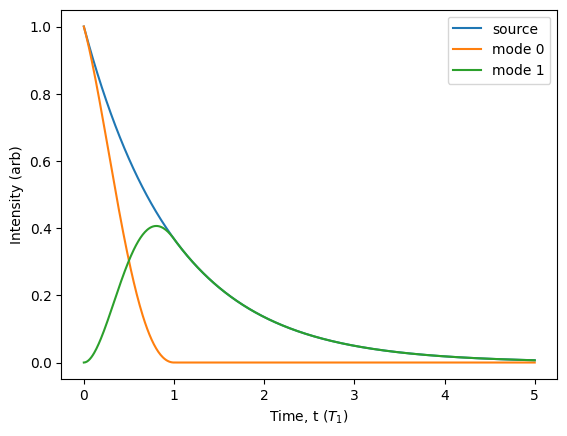

In [43]:
source = Source.fock(1)
p = Processor() // source // c
source.plot_lifetime(start=0, end=5, label='source')
p.plot_lifetime(port=0, start=0, end=5, label='mode 0')
p.plot_lifetime(port=1, start=0, end=5, label='mode 1').show()

## Loss

The loss component implements a non-unitary transformation on one mode that is defined by the matrix
$$
\hat{S}_\text{loss} = \begin{pmatrix}
\sqrt{\eta}
\end{pmatrix}.
$$
This is equivalent to a beam splitter (or linear) loss model where the amplitude of light dampened linearly. That is, a value of $\eta=1/2$ will halve the average photon number of the light.

\begin{tabular}{c|l|l}
\text{Symbol}&\text{Description}&\text{ZPG Parameter}\\\hline
$\eta & \text{The transmission efficiency}& \text{`efficiency'}\\
\end{tabular}

### Examples

By default, the loss component does nothing.

In [44]:
c = Circuit.loss()
c.default_parameters

{'efficiency': 1}

By evaluating it, we can verify the underlying model.

In [45]:
c.evaluate(t=0, parameters={'efficiency': 0.5})

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[0.70710678]]

Using the 'modes' keyword, we can apply the same loss value to multiple modes simultaneously. We may also specify the default efficiency value when instantiating the object. This can be done through the 'efficiency' keyword or by passing a dictionary using the 'parameters' keyword.

In [46]:
c = Circuit.loss(efficiency=0.5, modes=5)
c.evaluate(t=0)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[0.70710678 0.         0.         0.         0.        ]
 [0.         0.70710678 0.         0.         0.        ]
 [0.         0.         0.70710678 0.         0.        ]
 [0.         0.         0.         0.70710678 0.        ]
 [0.         0.         0.         0.         0.70710678]]

## Gate

The gate component implements a piece-wise time-independent non-unitary transformation on one mode that is defined by the matrix
$$
\hat{S}_\text{gate}(t) = \begin{pmatrix}
\sqrt{\eta(t)}
\end{pmatrix}.
$$
where $\eta(t)=1$ for $t$ within a specified interval of time and $\eta(t)=0$ otherwise.
This is equivalent to a switch where mode 1 is ignored and the function is a square pulse Like the switch, all parameters are user-defined.

### Examples

When instantiating, we can specify parameters directly as strings in the interval list. Similar to the loss component, we can also specify the number of modes that are impacted by the gate.

In [47]:
c = Circuit.gate(interval=['start', 'end'],
                 parameters={'start': 0, 'end': 1},
                 modes=3)
c.default_parameters

{'start': 0, 'end': 1}

The value of the scattering matrix will depend on time.

In [48]:
c.evaluate(t=-1)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

In [49]:
c.evaluate(t=0.5)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

In [50]:
c.evaluate(t=2)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

We can use this to truncate emission from a source, either to model a realistic protocol or to analyse its behaviour.

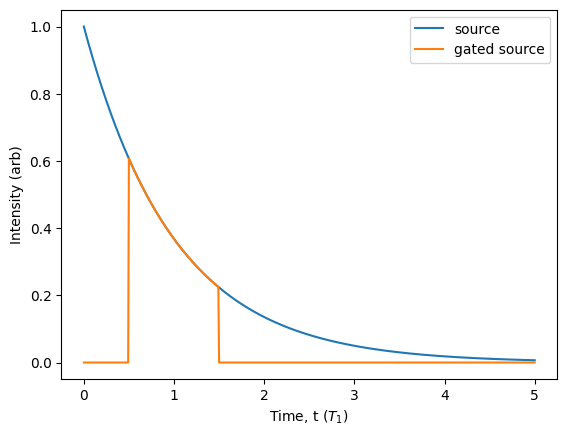

In [51]:
source = Source.fock(1)
p = Processor() // source // c
params = {'start': 0.5, 'end': 1.5}
source.plot_lifetime(start=0, end=5, label='source', parameters=params)
p.plot_lifetime(port=0, start=0, end=5, label='gated source', parameters=params).show()

## Haar random

The Haar random component is simply a Haar random unitary transformation applied to a specified number of modes. The unitary matrix is generated randomly using the QuTiP function ['rand_unitary_haar'](https://qutip.org/docs/latest/apidoc/functions.html?highlight=haar%20random#qutip.random_objects.rand_unitary_haar). The Haar random component has no parameters.

### Examples

We can specify the number of modes when creating the object.

In [52]:
c = Circuit.haar_random(modes=5)
c.default_parameters

{}

The circuit is not time dependent.

In [53]:
c.is_time_dependent()

False

In [54]:
c.evaluate(t=0)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = False
Qobj data =
[[ 0.13702859+0.82545822j -0.11795036-0.24177268j  0.25523323-0.03262515j
  -0.00921306+0.2251175j   0.32138874-0.08493341j]
 [-0.03647366-0.3914758j   0.17007563+0.02242474j  0.39134161+0.00671751j
   0.36050014+0.10139769j  0.72237264-0.02702445j]
 [-0.00480747+0.22917576j  0.45011604+0.73466783j  0.29492502-0.3114161j
  -0.06735432-0.00505036j -0.12646949+0.02442731j]
 [-0.14086906+0.23536336j  0.09196971+0.14726323j -0.32272182+0.2343928j
   0.83608659+0.09780093j -0.16406921+0.0011161j ]
 [-0.1087661 -0.07512364j -0.18442658-0.30282962j  0.48511374-0.44968073j
   0.30749724+0.03567809j -0.39517152+0.40898817j]]

## Custom

To make a custom circuit component, one can use the 'custom' method and specify the desired scattering matrix directly. Note that it doesn't need to be a unitary matrix, but to obtain physically-meaningful results, it should at least be a scattering matrix.

In [55]:
c = Circuit.custom(matrix=[[1, 0], [0, 0.5]])
c.evaluate(t=0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1.  0. ]
 [0.  0.5]]

Parameters can be introduced by providing a function that returns a QuTiP Qobj, along with a corresponding dictionary of default parameters.

In [56]:
from numpy import sqrt
c = Circuit.custom(matrix=lambda args: Qobj([[args['a'], 0], [0, args['b']]]) * Qobj([[1, 1], [1, -1]]) / sqrt(2),
                   parameters={'a': 1, 'b': 1})
c.evaluate(t=0, parameters={'a': 0.5, 'b': 0.8})

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.35355339  0.35355339]
 [ 0.56568542 -0.56568542]]

## Conversion from Perceval

Perceval provides many tools for building photonic circuits and also has many catalogue circuits built to perform linear-optical gates. These circuits can be converted to ZPGenerator simply through their underlying unitary transformation. This conversion cannot account for any heralding or post-processing steps, nor non-unitary components in Perceval.

In [57]:
from perceval import BS, catalog

### Examples

We can easily create a Hadamard variation of the beam splitter using the class method of BS in Perceval.

In [58]:
c = Circuit.from_perceval(BS.H())
c.evaluate(0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

We can also import complicated circuits such as a 12-mode post-processed Toffoli (CCZ) circuit.

In [59]:
c = Circuit.from_perceval(catalog['postprocessed ccz'].build_circuit())
c.evaluate(0)

Quantum object: dims = [[12], [12]], shape = (12, 12), type = oper, isherm = False
Qobj data =
[[ 0.50982453+0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.86027841+0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.50982453+0.j          0.        +0.j
   0.32116933+0.55628159j  0.        +0.j          0.        +0.j
   0.33039371+0.j         -0.16519685-0.28612934j -0.16519685+0.28612934j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.50982453+0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.86027841+0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.5098245